In [0]:
#To import the dataset from the website
import urllib.request
urllib.request.urlretrieve ("https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz","a.tar.gz")
import tarfile
tar = tarfile.open("a.tar.gz")
tar.extractall()
tar.close()

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa as lib
from librosa import display
from keras.utils.np_utils import to_categorical
import os
from tqdm import tqdm

Using TensorFlow backend.


In [9]:
#Loading the dataset to the dataframe
audio_df=pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")
audio_df.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [10]:
#To check the number of audio clips in each fold[1-10]
audio_df['fold'].value_counts()

4     990
5     936
3     925
2     888
1     873
7     838
10    837
6     823
9     816
8     806
Name: fold, dtype: int64

## **To visualize the mel spectrogram,chromagram of an audio clip**

In [91]:
#To load siren audio clip using librosa.load that returns the sampling rate of the audio signal
y,sr=lib.load("UrbanSound8K/audio/fold2/159743-8-0-0.wav")

mfccs = lib.feature.mfcc(y, sr, n_mfcc=40)
melspectrogram =lib.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000)
chroma_stft=lib.feature.chroma_stft(y=y, sr=sr,n_chroma=40)
chroma_cq =lib.feature.chroma_cqt(y=y, sr=sr,n_chroma=40)
chroma_cens =lib.feature.chroma_cens(y=y, sr=sr,n_chroma=40)

print(melspectrogram.shape,chroma_stft.shape,chroma_cq.shape,chroma_cens.shape,mfccs.shape)

(40, 173) (40, 173) (40, 173) (40, 173) (40, 173)


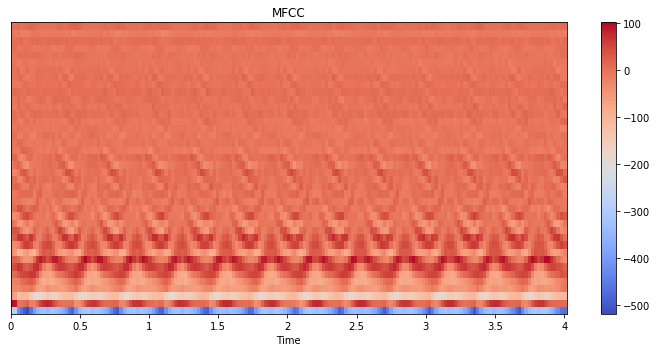

In [92]:
#MFCC of siren audio clip
plt.figure(figsize=(10,5))
lib.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

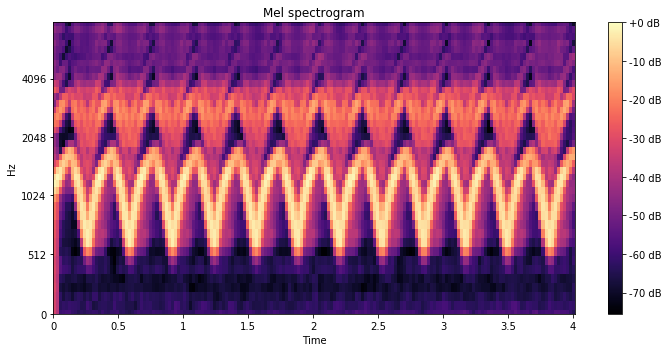

In [93]:
#Mel spectrogram of siren audio clip
plt.figure(figsize=(10,5))
lib.display.specshow(lib.power_to_db(melspectrogram,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

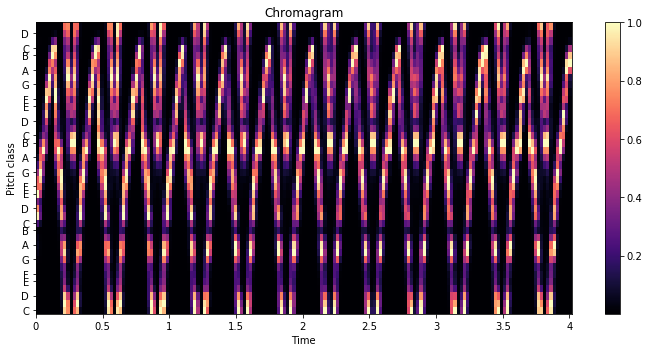

In [94]:
#Chromagram of siren audio clip
plt.figure(figsize=(10,5))
lib.display.specshow(chroma_stft, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()


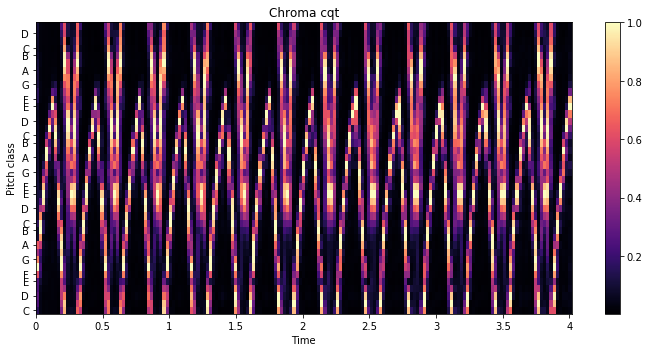

In [96]:
#Chroma sqt of siren audio clip
plt.figure(figsize=(10,5))
lib.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chroma cqt')
plt.tight_layout()

In [46]:

#Extract features from audio clips using Librosa.feature
x_train=[]
x_test=[]
y_train=[]
y_test=[]
path="UrbanSound8K/audio/fold"
for i in tqdm(range(len(audio_df))):
    fold_no=str(audio_df.iloc[i]["fold"])
    file=audio_df.iloc[i]["slice_file_name"]
    label=audio_df.iloc[i]["classID"]
    filename=path+fold_no+"/"+file
    #print(filename)
    y,sr=lib.load(filename)
    mfccs = np.mean(lib.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)
    melspectrogram = np.mean(lib.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000).T,axis=0)
    chroma_stft=np.mean(lib.feature.chroma_stft(y=y, sr=sr,n_chroma=40).T,axis=0)
    chroma_cq = np.mean(lib.feature.chroma_cqt(y=y, sr=sr,n_chroma=40).T,axis=0)
    chroma_cens = np.mean(lib.feature.chroma_cens(y=y, sr=sr,n_chroma=40).T,axis=0)
    features=np.reshape(np.vstack((mfccs,melspectrogram,chroma_stft,chroma_cq,chroma_cens)),(40,5))
    
    if(fold_no!='10'):
      x_train.append(features)
      y_train.append(label)
    else:
      x_test.append(features)
      y_test.append(label)

  1%|          | 67/8732 [00:52<1:56:23,  1.24it/s]/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
  1%|          | 68/8732 [00:53<2:00:23,  1.20it/s]/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
  1%|          | 69/8732 [00:54<2:03:21,  1.17it/s]/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
  1%|          | 71/8732 [00:56<2:06:15,  1.14it/s]/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequ

In [54]:
#Converting the lists into numpy arrays
Xtrain=np.array(x_train)
Xtest=np.array(x_test)
ytrain=np.array(y_train)
ytest=np.array(y_test)
print(Xtrain.shape,Xtest.shape,ytrain.shape,ytest.shape)

(7895, 40, 5) (837, 40, 5) (7895,) (837,)


In [0]:
#Export the train and test numpy arrays to a csv file
np.savetxt("train_data.csv", Xtrain2d, delimiter=",")
np.savetxt("test_data.csv",Xtest2d,delimiter=",")
np.savetxt("train_labels.csv",y_train,delimiter=",")
np.savetxt("test_labels.csv",y_test,delimiter=",")

In [64]:
#extracting data from csv files into numpy arrays
from numpy import genfromtxt
x_train1 = genfromtxt('train_data.csv', delimiter=',')
y_train1 = genfromtxt('train_labels.csv', delimiter=',')
x_test1 = genfromtxt('test_data.csv', delimiter=',')
y_test1 = genfromtxt('test_labels.csv', delimiter=',')
x_train1.shape,x_test1.shape,y_train1.shape,y_test1.shape

((7895, 200), (837, 200), (7895,), (837,))

In [65]:
#One hot encoding of the output class
y_train1 = to_categorical(y_train1, num_classes=10)
y_test1 = to_categorical(y_test1, num_classes=10)
print(y_train1.shape,y_test1.shape)

(7895, 10) (837, 10)


In [66]:
#Reshaping into 2d to save in csv format
x_train1=np.reshape(x_train1,(x_train1.shape[0], 40,5))
x_test1=np.reshape(x_test1,(x_test1.shape[0], 40,5))
x_train1.shape,x_test1.shape

((7895, 40, 5), (837, 40, 5))

In [68]:
#reshaping to shape required by CNN
x_train1=np.reshape(x_train1,(x_train1.shape[0], 40,5,1))
x_test1=np.reshape(x_test1,(x_test1.shape[0], 40,5,1))
print(x_train1.shape,x_test1.shape)

(7895, 40, 5, 1) (837, 40, 5, 1)


# **Building a Convolutional neural network**

In [71]:
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers


model = Sequential()
model.add(Conv2D(64,kernel_size=5,strides=1,padding="same",activation="relu",input_shape=(40,5,1)))
model.add(MaxPooling2D(padding="same"))

model.add(Conv2D(128,kernel_size=5,strides=1,padding="same",activation="relu"))
model.add(MaxPooling2D(padding="same"))
model.add(Dropout(0.25))

model.add(Conv2D(256,kernel_size=5,strides=1,padding="same",activation="relu"))
model.add(MaxPooling2D(padding="same"))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.25))

model.add(Dense(256,activation="relu"))
model.add(Dropout(0.25))

model.add(Dense(128,activation="relu"))
model.add(Dropout(0.25))

model.add(Dense(10,activation="softmax"))

model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 40, 5, 64)         1664      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 20, 3, 64)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 20, 3, 128)        204928    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 10, 2, 128)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 10, 2, 128)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 10, 2, 256)        819456    
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 5, 1, 256)        

In [77]:
#Fitting the model with the train data
history = model.fit(x_train1,y_train1,batch_size=50,epochs=50,validation_data=(x_test1,y_test1))

Train on 7895 samples, validate on 837 samples
Epoch 1/50
7895/7895 [==============================] - 3s 400us/step - loss: 0.1621 - acc: 0.9560 - val_loss: 1.5010 - val_acc: 0.6738
Epoch 2/50
7895/7895 [==============================] - 3s 392us/step - loss: 0.1559 - acc: 0.9593 - val_loss: 1.4580 - val_acc: 0.6906
Epoch 3/50
7895/7895 [==============================] - 3s 383us/step - loss: 0.1923 - acc: 0.9498 - val_loss: 1.2505 - val_acc: 0.7001
Epoch 4/50
7895/7895 [==============================] - 3s 385us/step - loss: 0.1646 - acc: 0.9544 - val_loss: 1.6699 - val_acc: 0.6882
Epoch 5/50
7895/7895 [==============================] - 3s 388us/step - loss: 0.1613 - acc: 0.9548 - val_loss: 1.4110 - val_acc: 0.7001
Epoch 6/50
7895/7895 [==============================] - 3s 384us/step - loss: 0.0952 - acc: 0.9721 - val_loss: 1.2418 - val_acc: 0.7276
Epoch 7/50
7895/7895 [==============================] - 3s 386us/step - loss: 0.1130 - acc: 0.9678 - val_loss: 1.6817 - val_acc: 0.6894
E

In [78]:
score = model.evaluate(x_test1, y_test1, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.571681703076995
Test accuracy: 0.7132616487455197


In [0]:
y_pred = model.predict_classes(x_test1)

In [89]:
print("Predicted classes of the test audio clips: \n",y_pred)

Predicted classes of the test audio clips: 
 [9 9 1 1 1 3 3 3 3 3 2 2 2 2 2 2 3 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 5 5 7 7 5 9 2 9 9 9 9 1 9 9 9 9 9 9 3 3 9
 9 9 9 9 9 8 8 3 3 3 8 8 3 8 7 3 3 9 9 5 5 5 5 5 5 5 5 5 5 0 0 0 3 3 2 2 3
 2 3 3 2 2 2 2 2 2 2 2 2 9 2 8 9 9 9 9 0 9 9 9 5 5 9 3 3 3 3 2 2 2 2 2 2 2
 3 4 9 9 5 9 9 9 9 9 9 9 9 9 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 9 3 3 3 3 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 7 7 7 4 7 4 4 4 4 7 7 4 4 4 7 4 4 7 7 7 7 7 7 4 7 4 4 4 4 7 7 4
 7 7 7 4 7 7 7 7 7 7 7 4 4 4 4 4 4 4 4 7 7 7 4 7 4 7 7 4 4 3 3 2 2 2 2 2 2
 2 2 9 9 9 9 9 9 9 6 8 8 8 8 8 8 8 8 3 4 4 5 2 2 2 2 7 7 0 2 9 0 0 9 2 0 0
 2 2 0 2 2 0 7 7 0 0 6 4 2 4 6 2 1 2 2 2 2 2 2 2 9 9 9 9 9 9 6 6 6 6 6 6 6
 3 3 3 7 1 7 7 7 7 7 7 7 7 7 7 1 2 2 2 2 2 2 2 2 1 5 4 4 4 4 4 5 5 5 4 5 5
 4 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 8 3 3 4 4 4 4 8 2
 8 8 2 2 2 2 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 0 0 